In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pylab import rcParams
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve, classification_report
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from numpy.random import seed
import os

from keras import optimizers, Sequential
from keras.utils import plot_model
from keras.layers import LSTM, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard


from numpy.random import seed
seed(7)
from tensorflow import set_random_seed
set_random_seed(2)
SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.1
rcParams['figure.figsize'] = 8, 6

In [2]:
# load with non-Nan valued data
path = 'H:\\Project\\AI Projects\\Sepsis Detection New' 
train_data = pd.read_csv(os.path.join(path, 'Train_data.csv'))
test_data = pd.read_csv(os.path.join(path, 'Test_data.csv'))
from sklearn.model_selection import train_test_split
test_data.dropna(inplace = True)
train_data.dropna(inplace = True)

In [ ]:
train_data, valid_data = train_test_split(train_data, test_size=DATA_SPLIT_PCT, random_state=SEED )

In [3]:
# scaling
scaler = StandardScaler().fit(train_data.loc[train_data['SepsisLabel'] == 0].iloc[:,:-1])
df_train_0_x = scaler.transform(train_data.loc[train_data['SepsisLabel'] == 0].iloc[:,:-1])
df_valid_0_x = scaler.transform(valid_data.loc[valid_data['SepsisLabel'] == 0].iloc[:,:-1])
df_valid_x = scaler.transform(valid_data.iloc[:,:-1])
df_test_0_x = scaler.transform(test_data.loc[test_data['SepsisLabel'] == 0].iloc[:,:-1])
df_test_x = scaler.transform(test_data.iloc[:,:-1])

## Dense Layer AutoEncoder

In [4]:
# Define Model
nb_epoch = 50
batch_size = 128
input_dim = df_train_0_x.shape[1] #num of predictor variables, 
encoding_dim = 32
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-3

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="relu", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(encoding_dim, activation="relu")(decoder)
decoder = Dense(input_dim, activation="linear")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1312      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                1320      
Total params: 3,976
Trainable params: 3,976
Non-trainable params: 0
_________________________________________________________

In [5]:
# Training Model
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')
cp = ModelCheckpoint(filepath="autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)
tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)
history = autoencoder.fit(df_train_0_x, df_train_0_x,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(df_valid_0_x, df_valid_0_x),
                    verbose=1,
                    callbacks=[cp, tb]).history


Train on 1199588 samples, validate on 133221 samples


Epoch 1/50
1199588/1199588 [==============================] - 26s 22us/step - loss: 0.5945 - accuracy: 0.2500 - val_loss: 0.4507 - val_accuracy: 0.2979

Epoch 2/50
1199588/1199588 [==============================] - 20s 17us/step - loss: 0.4329 - accuracy: 0.2991 - val_loss: 0.4021 - val_accuracy: 0.2973
Epoch 3/50
1199588/1199588 [==============================] - 20s 17us/step - loss: 0.3814 - accuracy: 0.3139 - val_loss: 0.3559 - val_accuracy: 0.3623
Epoch 4/50
1199588/1199588 [==============================] - 23s 19us/step - loss: 0.3416 - accuracy: 0.3785 - val_loss: 0.3238 - val_accuracy: 0.3814
Epoch 5/50
1199588/1199588 [==============================] - 22s 18us/step - loss: 0.3237 - accuracy: 0.3872 - val_loss: 0.3101 - val_accuracy: 0.3671
Epoch 6/50
1199588/1199588 [==============================] - 19s 16us/step - loss: 0.3136 - accuracy: 0.3923 - val_loss: 0.2993 - val_accuracy: 0.3985
Epoch 7/50
1199588/1199588 [===

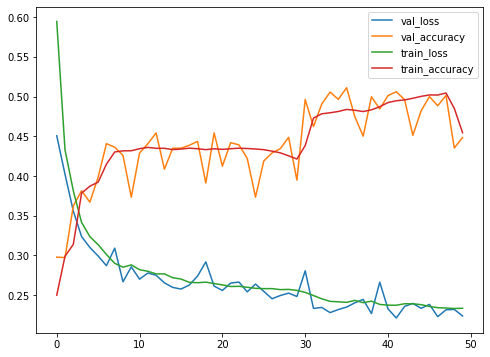

In [6]:
# plot acc and loss
y = range(0,len(history['val_loss']))
plt.figure()
plt.plot(y, history['val_loss'], label = 'val_loss')
plt.plot(y, history['val_accuracy'], label = 'val_accuracy')
plt.plot(y, history['loss'], label = 'train_loss')
plt.plot(y, history['accuracy'], label = 'train_accuracy')
plt.legend()
plt.show()

C:\Users\SURAJ KUMAR\AppData\Local\conda\conda\envs\PythonCPU\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


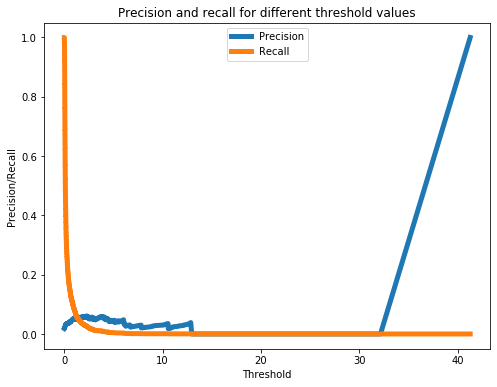

In [7]:
# Identifying Best Threshold Value
valid_x_predictions = autoencoder.predict(df_valid_x)
mse = np.mean(np.power(df_valid_x - valid_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': valid_data['SepsisLabel']})
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

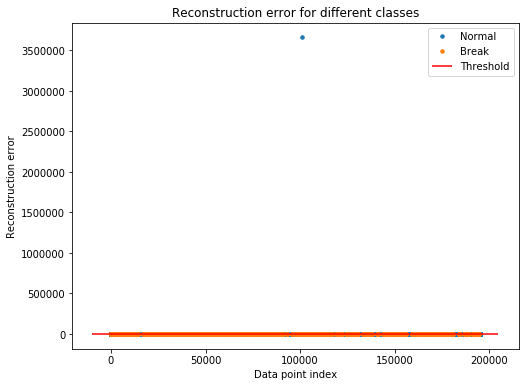

In [12]:
# check on Test data
test_x_predictions = autoencoder.predict(df_test_x)
mse = np.mean(np.power(df_test_x - test_x_predictions, 2), axis=1)
error_df_test = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_data['SepsisLabel']})
error_df_test = error_df_test.reset_index()
threshold_fixed = 0.4
groups = error_df_test.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

              precision    recall  f1-score   support

           0       0.98      0.90      0.94    133221
           1       0.04      0.20      0.06      2488

    accuracy                           0.89    135709
   macro avg       0.51      0.55      0.50    135709
weighted avg       0.97      0.89      0.92    135709



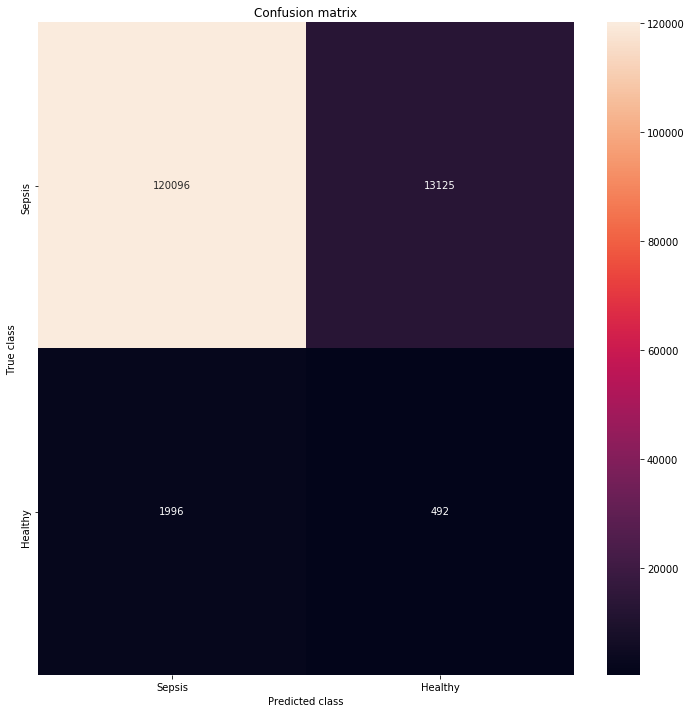

In [13]:
# Confusion Matrix
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
print(classification_report(error_df.True_class, pred_y))
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=['Sepsis', 'Healthy'], yticklabels=['Sepsis', 'Healthy'], annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

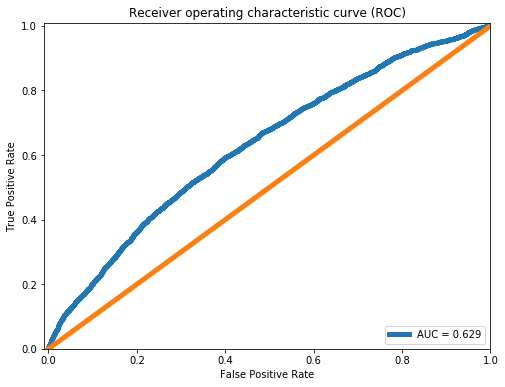

In [14]:
# AU ROC
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)
plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
# AUROC == 0.629

## on data with less feature

In [16]:
# selecteing features
train_data, valid_data = train_test_split(train_data, test_size=DATA_SPLIT_PCT, random_state=SEED )
features = ['HR', 'Temp', 'DBP', 'SBP', 'Resp', 'Platelets', 'Calcium', 'Glucose', 'Age', 'Gender', 'HospAdmTime', 'ICULOS','pH', 'SepsisLabel']
train_data = train_data[features]
valid_data = valid_data[features]
test_data = test_data[features]

In [17]:
# scaling
scaler = StandardScaler().fit(train_data.loc[train_data['SepsisLabel'] == 0].iloc[:,:-1])
df_train_0_x = scaler.transform(train_data.loc[train_data['SepsisLabel'] == 0].iloc[:,:-1])
df_valid_0_x = scaler.transform(valid_data.loc[valid_data['SepsisLabel'] == 0].iloc[:,:-1])
df_valid_x = scaler.transform(valid_data.iloc[:,:-1])
df_test_0_x = scaler.transform(test_data.loc[test_data['SepsisLabel'] == 0].iloc[:,:-1])
df_test_x = scaler.transform(test_data.iloc[:,:-1])

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 13)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 16)                224       
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_13 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_14 (Dense)             (None, 16)                144       
_________________________________________________________________
dense_15 (Dense)             (None, 13)                221       
Total params: 797
Trainable params: 797
Non-trainable params: 0
_____________________________________________________________

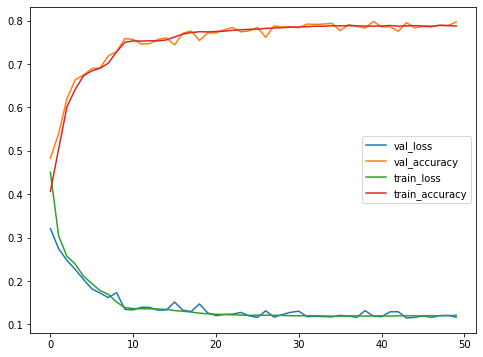

C:\Users\SURAJ KUMAR\AppData\Local\conda\conda\envs\PythonCPU\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


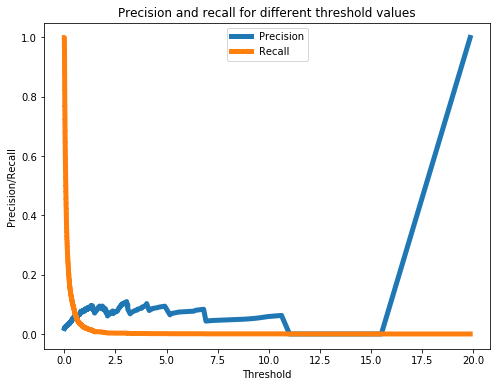

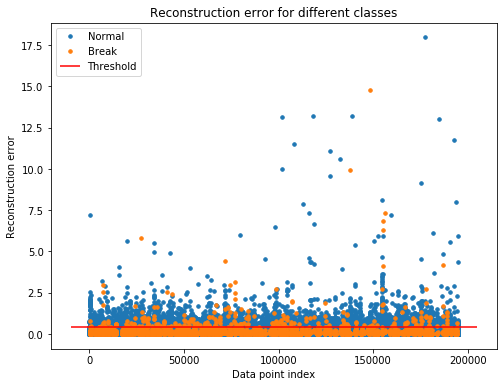

              precision    recall  f1-score   support

           0       0.98      0.96      0.97    133221
           1       0.05      0.10      0.07      2488

    accuracy                           0.95    135709
   macro avg       0.52      0.53      0.52    135709
weighted avg       0.97      0.95      0.96    135709



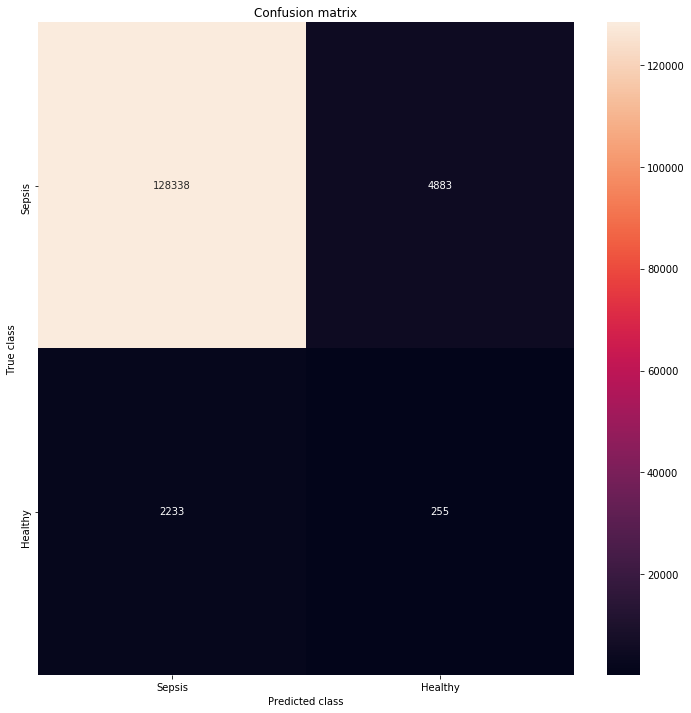

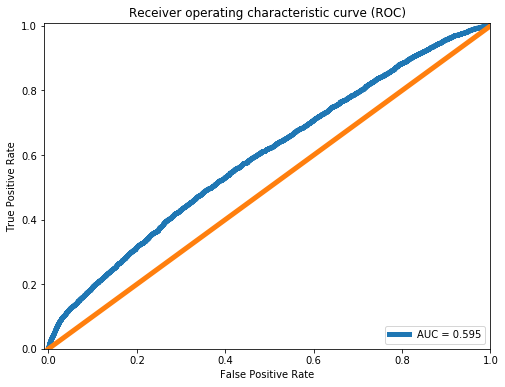

In [19]:
# Define Model
nb_epoch = 50
batch_size = 128
input_dim = df_train_0_x.shape[1] #num of predictor variables, 
encoding_dim = 16
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-3

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="relu", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(encoding_dim, activation="relu")(decoder)
decoder = Dense(input_dim, activation="linear")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()



# Training Model
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')
cp = ModelCheckpoint(filepath="autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)
tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)
history = autoencoder.fit(df_train_0_x, df_train_0_x,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(df_valid_0_x, df_valid_0_x),
                    verbose=1,
                    callbacks=[cp, tb]).history


# plot acc and loss
y = range(0,len(history['val_loss']))
plt.figure()
plt.plot(y, history['val_loss'], label = 'val_loss')
plt.plot(y, history['val_accuracy'], label = 'val_accuracy')
plt.plot(y, history['loss'], label = 'train_loss')
plt.plot(y, history['accuracy'], label = 'train_accuracy')
plt.legend()
plt.show()


# Identifying Best Threshold Value
valid_x_predictions = autoencoder.predict(df_valid_x)
mse = np.mean(np.power(df_valid_x - valid_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': valid_data['SepsisLabel']})
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()


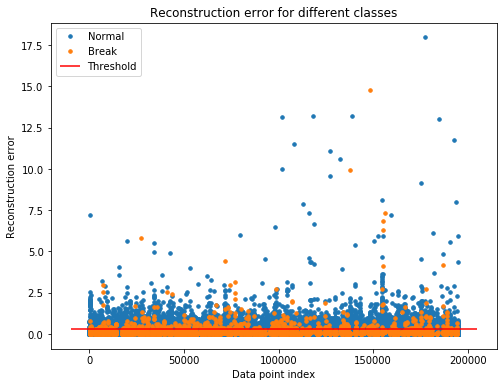

              precision    recall  f1-score   support

           0       0.98      0.94      0.96    133221
           1       0.04      0.14      0.06      2488

    accuracy                           0.92    135709
   macro avg       0.51      0.54      0.51    135709
weighted avg       0.97      0.92      0.94    135709



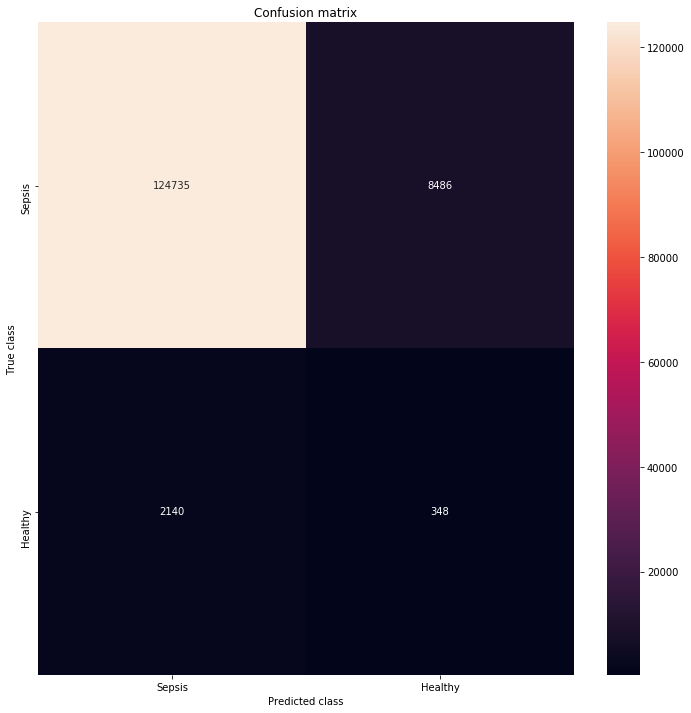

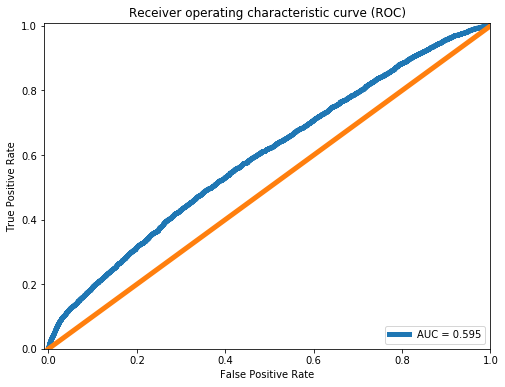

In [21]:

# check on Test data
test_x_predictions = autoencoder.predict(df_test_x)
mse = np.mean(np.power(df_test_x - test_x_predictions, 2), axis=1)
error_df_test = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_data['SepsisLabel']})
error_df_test = error_df_test.reset_index()
threshold_fixed = 0.3
groups = error_df_test.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();


# Confusion Matrix
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
print(classification_report(error_df.True_class, pred_y))
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=['Sepsis', 'Healthy'], yticklabels=['Sepsis', 'Healthy'], annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()


# AU ROC
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)
plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
# AUROC == 0.595

## categorical data

In [4]:
# Data with categorical version
# changing data to categorical

# HR = (normal(60-90), down, high)
# DBP = (normal(70-80), lower, higher)
# SBP = (normal(100-120), lower, higher)
# Age = (children(< = 14), teenage(15-21),adult(21-45), old(>45))
# Temp = (normal(35-38), lower, higher)
# Resp = (normal(14-18), lower, higher)
# pH = (normal(7.35 - 7.45), lower, higher)
# Platelets = (normal(240 - 300), lower, higher)
bin_age = [0,14,21,45,120]
label_age = ['children', 'teen', 'adult', 'old']
bin_HR = [0,60,90,200]
label_HR = ['down', 'normal', 'higher']
bin_SBP = [0,100,121,300]
label_SBP = ['down', 'normal', 'higher']
bin_DBP = [0,70,81,300]
label_DBP = ['down', 'normal', 'higher']
bin_Temp = [0,35,39,70]
label_Temp = ['down', 'normal', 'higher']
bin_Resp = [0,14,19,40]
label_Resp = ['down', 'normal', 'higher']
bin_pH = [0,7.35,7.46,10]
label_pH = ['down', 'normal', 'higher']
bin_Platelets = [0,240,301,1000]
label_Platelets = ['down', 'normal', 'higher']
train_data['Age'] = pd.cut(train_data['Age'], bins = bin_age, labels = label_age, right = False)
test_data['Age'] = pd.cut(test_data['Age'], bins = bin_age, labels = label_age, right = False)
train_data['HR'] = pd.cut(train_data['HR'], bins = bin_HR, labels = label_HR, right = False)
test_data['HR'] = pd.cut(test_data['HR'], bins = bin_HR, labels = label_HR, right = False)
train_data['SBP'] = pd.cut(train_data['SBP'], bins = bin_SBP, labels = label_SBP, right = False)
test_data['SBP'] = pd.cut(test_data['SBP'], bins = bin_SBP, labels = label_SBP, right = False)
train_data['DBP'] = pd.cut(train_data['DBP'], bins = bin_DBP, labels = label_DBP, right = False)
test_data['DBP'] = pd.cut(test_data['DBP'], bins = bin_DBP, labels = label_DBP, right = False)
train_data['Temp'] = pd.cut(train_data['Temp'], bins = bin_Temp, labels = label_Temp, right = False)
test_data['Temp'] = pd.cut(test_data['Temp'], bins = bin_Temp, labels = label_Temp, right = False)
train_data['Resp'] = pd.cut(train_data['Resp'], bins = bin_Resp, labels = label_Resp, right = False)
test_data['Resp'] = pd.cut(test_data['Resp'], bins = bin_Resp, labels = label_Resp, right = False)
train_data['pH'] = pd.cut(train_data['pH'], bins = bin_pH, labels = label_pH, right = False)
test_data['pH'] = pd.cut(test_data['pH'], bins = bin_pH, labels = label_pH, right = False)
train_data['Platelets'] = pd.cut(train_data['Platelets'], bins = bin_Platelets, labels = label_Platelets, right = False)
test_data['Platelets'] = pd.cut(test_data['Platelets'], bins = bin_Platelets, labels = label_Platelets, right = False)
train_data, valid_data = train_test_split(train_data, test_size=DATA_SPLIT_PCT, random_state=SEED )

In [7]:
# converting OneHotEncoder
train_data = pd.get_dummies(train_data)
valid_data = pd.get_dummies(valid_data)
test_data = pd.get_dummies(test_data)

col_seq = [i for i in train_data.columns if i != 'SepsisLabel']
col_seq.append('SepsisLabel')
train_data = train_data.reindex(columns = col_seq)
test_data = test_data.reindex(columns = col_seq)
valid_data = pd.get_dummies(valid_data)

# scaling
scaler = StandardScaler().fit(train_data.loc[train_data['SepsisLabel'] == 0].iloc[:,:-1])
df_train_0_x = scaler.transform(train_data.loc[train_data['SepsisLabel'] == 0].iloc[:,:-1])
df_valid_0_x = scaler.transform(valid_data.loc[valid_data['SepsisLabel'] == 0].iloc[:,:-1])
df_valid_x = scaler.transform(valid_data.iloc[:,:-1])
df_test_0_x = scaler.transform(test_data.loc[test_data['SepsisLabel'] == 0].iloc[:,:-1])
df_test_x = scaler.transform(test_data.iloc[:,:-1])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 57)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1856      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_5 (Dense)              (None, 57)                1881      
Total params: 5,081
Trainable params: 5,081
Non-trainable params: 0
_________________________________________________________

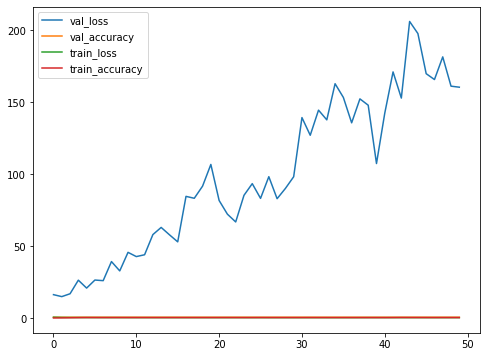

C:\Users\SURAJ KUMAR\AppData\Local\conda\conda\envs\PythonCPU\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


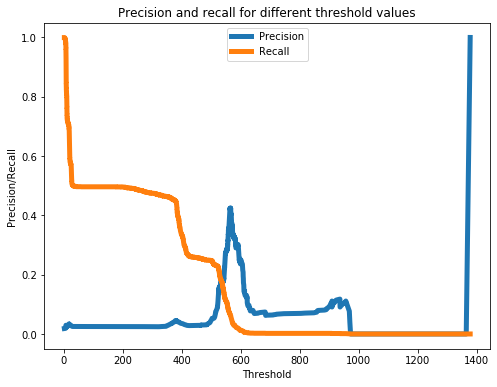

In [8]:
# Define Model
nb_epoch = 50
batch_size = 128
input_dim = df_train_0_x.shape[1] #num of predictor variables, 
encoding_dim = 32
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-3

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="relu", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(encoding_dim, activation="relu")(decoder)
decoder = Dense(input_dim, activation="linear")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()



# Training Model
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')
cp = ModelCheckpoint(filepath="autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)
tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)
history = autoencoder.fit(df_train_0_x, df_train_0_x,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(df_valid_0_x, df_valid_0_x),
                    verbose=1,
                    callbacks=[cp, tb]).history


# plot acc and loss
y = range(0,len(history['val_loss']))
plt.figure()
plt.plot(y, history['val_loss'], label = 'val_loss')
plt.plot(y, history['val_accuracy'], label = 'val_accuracy')
plt.plot(y, history['loss'], label = 'train_loss')
plt.plot(y, history['accuracy'], label = 'train_accuracy')
plt.legend()
plt.show()


# Identifying Best Threshold Value
valid_x_predictions = autoencoder.predict(df_valid_x)
mse = np.mean(np.power(df_valid_x - valid_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': valid_data['SepsisLabel']})
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()


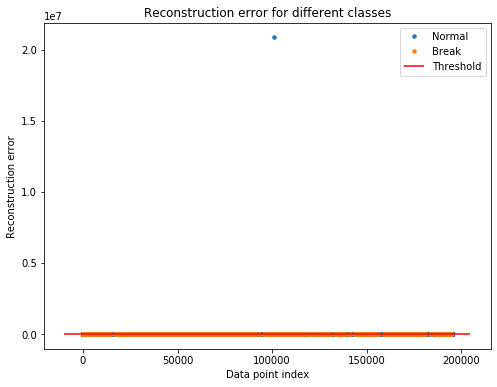

              precision    recall  f1-score   support

           0       0.99      0.98      0.98    133221
           1       0.15      0.22      0.17      2488

    accuracy                           0.96    135709
   macro avg       0.57      0.60      0.58    135709
weighted avg       0.97      0.96      0.97    135709



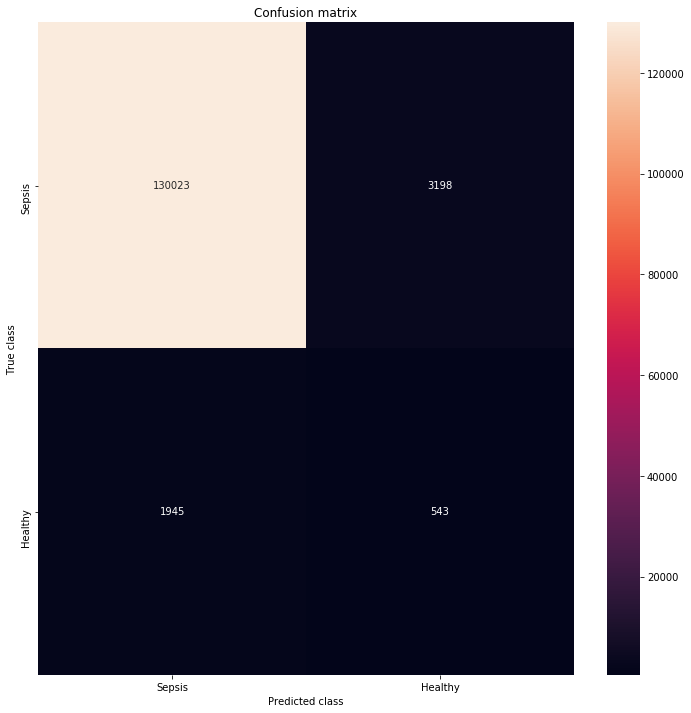

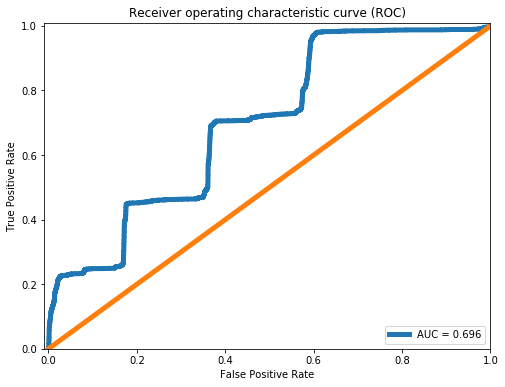

In [12]:

# check on Test data
test_x_predictions = autoencoder.predict(df_test_x)
mse = np.mean(np.power(df_test_x - test_x_predictions, 2), axis=1)
error_df_test = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_data['SepsisLabel']})
error_df_test = error_df_test.reset_index()
threshold_fixed = 525
groups = error_df_test.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();


# Confusion Matrix
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
print(classification_report(error_df.True_class, pred_y))
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=['Sepsis', 'Healthy'], yticklabels=['Sepsis', 'Healthy'], annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()


# AU ROC
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)
plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
# AUROC == 0.696

## Categorical with selected feature

In [4]:
# Data with categorical version
# changing data to categorical

# HR = (normal(60-90), down, high)
# DBP = (normal(70-80), lower, higher)
# SBP = (normal(100-120), lower, higher)
# Age = (children(< = 14), teenage(15-21),adult(21-45), old(>45))
# Temp = (normal(35-38), lower, higher)
# Resp = (normal(14-18), lower, higher)
# pH = (normal(7.35 - 7.45), lower, higher)
# Platelets = (normal(240 - 300), lower, higher)
bin_age = [0,14,21,45,120]
label_age = ['children', 'teen', 'adult', 'old']
bin_HR = [0,60,90,200]
label_HR = ['down', 'normal', 'higher']
bin_SBP = [0,100,121,300]
label_SBP = ['down', 'normal', 'higher']
bin_DBP = [0,70,81,300]
label_DBP = ['down', 'normal', 'higher']
bin_Temp = [0,35,39,70]
label_Temp = ['down', 'normal', 'higher']
bin_Resp = [0,14,19,40]
label_Resp = ['down', 'normal', 'higher']
bin_pH = [0,7.35,7.46,10]
label_pH = ['down', 'normal', 'higher']
bin_Platelets = [0,240,301,1000]
label_Platelets = ['down', 'normal', 'higher']
train_data['Age'] = pd.cut(train_data['Age'], bins = bin_age, labels = label_age, right = False)
test_data['Age'] = pd.cut(test_data['Age'], bins = bin_age, labels = label_age, right = False)
train_data['HR'] = pd.cut(train_data['HR'], bins = bin_HR, labels = label_HR, right = False)
test_data['HR'] = pd.cut(test_data['HR'], bins = bin_HR, labels = label_HR, right = False)
train_data['SBP'] = pd.cut(train_data['SBP'], bins = bin_SBP, labels = label_SBP, right = False)
test_data['SBP'] = pd.cut(test_data['SBP'], bins = bin_SBP, labels = label_SBP, right = False)
train_data['DBP'] = pd.cut(train_data['DBP'], bins = bin_DBP, labels = label_DBP, right = False)
test_data['DBP'] = pd.cut(test_data['DBP'], bins = bin_DBP, labels = label_DBP, right = False)
train_data['Temp'] = pd.cut(train_data['Temp'], bins = bin_Temp, labels = label_Temp, right = False)
test_data['Temp'] = pd.cut(test_data['Temp'], bins = bin_Temp, labels = label_Temp, right = False)
train_data['Resp'] = pd.cut(train_data['Resp'], bins = bin_Resp, labels = label_Resp, right = False)
test_data['Resp'] = pd.cut(test_data['Resp'], bins = bin_Resp, labels = label_Resp, right = False)
train_data['pH'] = pd.cut(train_data['pH'], bins = bin_pH, labels = label_pH, right = False)
test_data['pH'] = pd.cut(test_data['pH'], bins = bin_pH, labels = label_pH, right = False)
train_data['Platelets'] = pd.cut(train_data['Platelets'], bins = bin_Platelets, labels = label_Platelets, right = False)
test_data['Platelets'] = pd.cut(test_data['Platelets'], bins = bin_Platelets, labels = label_Platelets, right = False)

# seleceting features
features = ['HR', 'Temp', 'DBP', 'SBP', 'Resp', 'Platelets', 'Calcium', 'Glucose', 'Age', 'Gender', 'HospAdmTime', 'ICULOS','pH', 'SepsisLabel']
train_data = train_data[features]
test_data = test_data[features]

train_data, valid_data = train_test_split(train_data, test_size=DATA_SPLIT_PCT, random_state=SEED )

In [5]:
# converting OneHotEncoder
train_data = pd.get_dummies(train_data)
valid_data = pd.get_dummies(valid_data)
test_data = pd.get_dummies(test_data)

col_seq = [i for i in train_data.columns if i != 'SepsisLabel']
col_seq.append('SepsisLabel')
train_data = train_data.reindex(columns = col_seq)
test_data = test_data.reindex(columns = col_seq)
valid_data = pd.get_dummies(valid_data)

# scaling
scaler = StandardScaler().fit(train_data.loc[train_data['SepsisLabel'] == 0].iloc[:,:-1])
df_train_0_x = scaler.transform(train_data.loc[train_data['SepsisLabel'] == 0].iloc[:,:-1])
df_valid_0_x = scaler.transform(valid_data.loc[valid_data['SepsisLabel'] == 0].iloc[:,:-1])
df_valid_x = scaler.transform(valid_data.iloc[:,:-1])
df_test_0_x = scaler.transform(test_data.loc[test_data['SepsisLabel'] == 0].iloc[:,:-1])
df_test_x = scaler.transform(test_data.iloc[:,:-1])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 28)                868       
_________________________________________________________________
dense_2 (Dense)              (None, 14)                406       
_________________________________________________________________
dense_3 (Dense)              (None, 14)                210       
_________________________________________________________________
dense_4 (Dense)              (None, 28)                420       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                870       
Total params: 2,774
Trainable params: 2,774
Non-trainable params: 0
_________________________________________________________

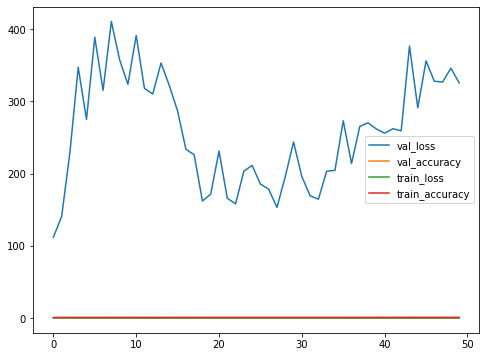

C:\Users\SURAJ KUMAR\AppData\Local\conda\conda\envs\PythonCPU\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


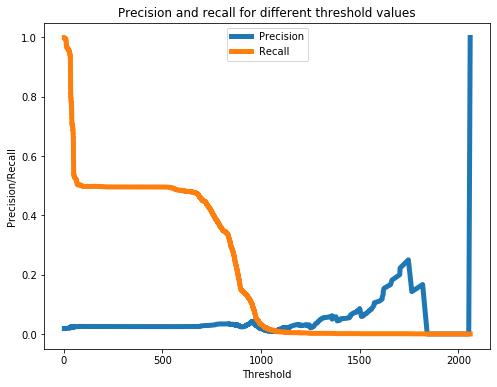

In [6]:
# Define Model
nb_epoch = 50
batch_size = 128
input_dim = df_train_0_x.shape[1] #num of predictor variables, 
encoding_dim = 28
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-3

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="relu", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(encoding_dim, activation="relu")(decoder)
decoder = Dense(input_dim, activation="linear")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()



# Training Model
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')
cp = ModelCheckpoint(filepath="autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)
tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)
history = autoencoder.fit(df_train_0_x, df_train_0_x,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(df_valid_0_x, df_valid_0_x),
                    verbose=1,
                    callbacks=[cp, tb]).history


# plot acc and loss
y = range(0,len(history['val_loss']))
plt.figure()
plt.plot(y, history['val_loss'], label = 'val_loss')
plt.plot(y, history['val_accuracy'], label = 'val_accuracy')
plt.plot(y, history['loss'], label = 'train_loss')
plt.plot(y, history['accuracy'], label = 'train_accuracy')
plt.legend()
plt.show()


# Identifying Best Threshold Value
valid_x_predictions = autoencoder.predict(df_valid_x)
mse = np.mean(np.power(df_valid_x - valid_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': valid_data['SepsisLabel']})
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()


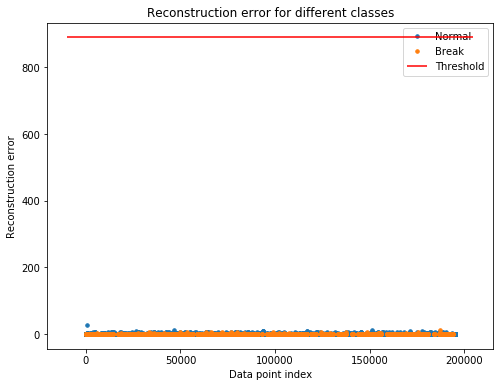

              precision    recall  f1-score   support

           0       0.98      0.88      0.93    133221
           1       0.03      0.18      0.05      2488

    accuracy                           0.87    135709
   macro avg       0.51      0.53      0.49    135709
weighted avg       0.97      0.87      0.91    135709



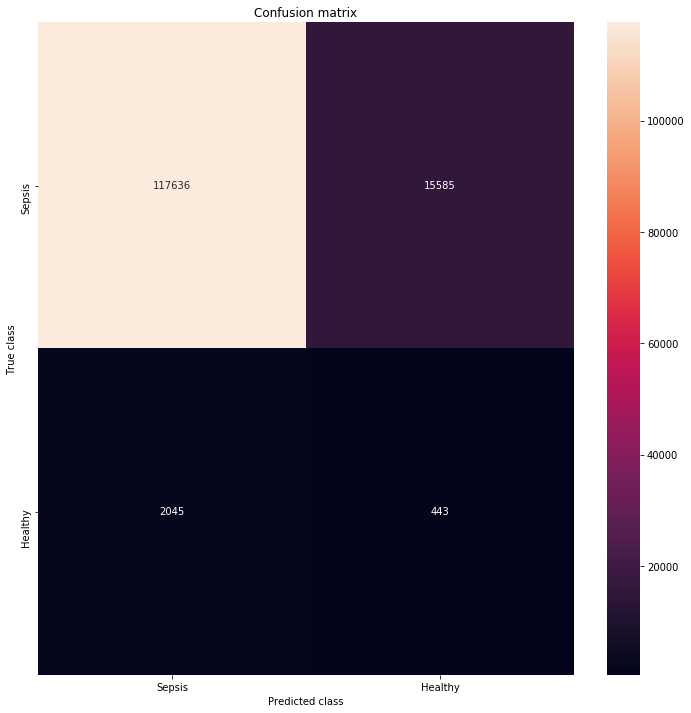

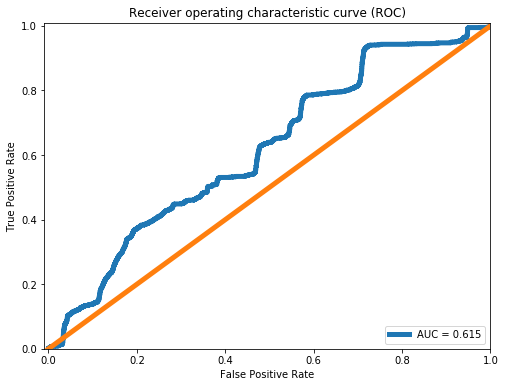

In [7]:

# check on Test data
test_x_predictions = autoencoder.predict(df_test_x)
mse = np.mean(np.power(df_test_x - test_x_predictions, 2), axis=1)
error_df_test = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_data['SepsisLabel']})
error_df_test = error_df_test.reset_index()
threshold_fixed = 890
groups = error_df_test.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();


# Confusion Matrix
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
print(classification_report(error_df.True_class, pred_y))
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=['Sepsis', 'Healthy'], yticklabels=['Sepsis', 'Healthy'], annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()


# AU ROC
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)
plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
# AUROC == 0.615